In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier  # Replaced RandomForestClassifier with LightGBM
from sklearn.metrics import classification_report, confusion_matrix

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Explainable AI
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Replace 'fetal_health.csv' with your actual file path if different
data = pd.read_csv('/content/fetal_health.csv')

# Display the first five rows to verify
print("First five rows of the dataset:")
print(data.head())

# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")

# Check the data types of each column
print("\nData Types:")
print(data.dtypes)

# Display summary statistics
print("\nSummary Statistics:")
print(data.describe())

First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 


Missing Values in Each Column:
baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogra

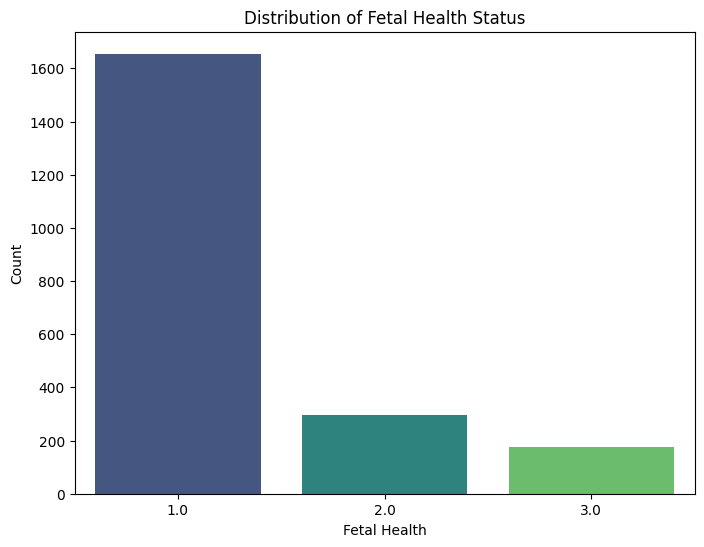


Data Types After Conversion:
baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                     

In [3]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='fetal_health', data=data, palette='viridis')
plt.title('Distribution of Fetal Health Status')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

# Convert 'fetal_health' to integer
data['fetal_health'] = data['fetal_health'].astype(int)

# Verify the conversion
print("\nData Types After Conversion:")
print(data.dtypes)


Dataset with Mapped Labels:
   fetal_health fetal_health_label
0             2            Suspect
1             1             Normal
2             1             Normal
3             1             Normal
4             1             Normal


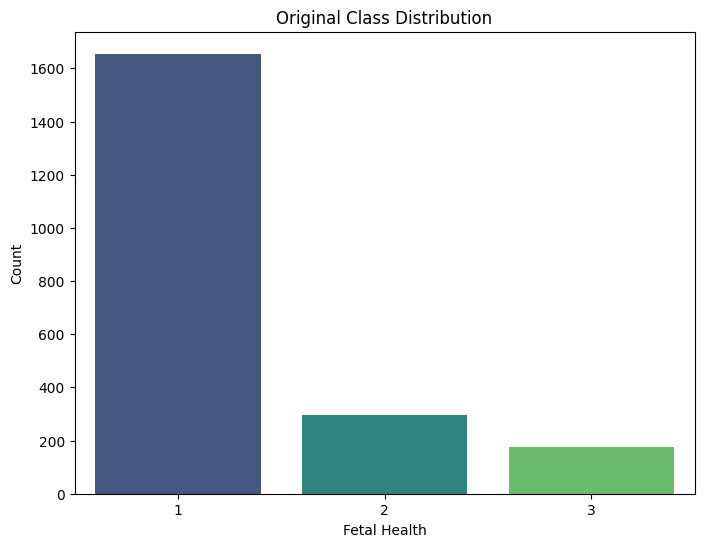

In [4]:
# Mapping numerical classes to descriptive labels
health_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
data['fetal_health_label'] = data['fetal_health'].map(health_mapping)

# Display the updated DataFrame
print("\nDataset with Mapped Labels:")
print(data[['fetal_health', 'fetal_health_label']].head())

# Features (all columns except 'fetal_health' and 'fetal_health_label')
X = data.drop(['fetal_health', 'fetal_health_label'], axis=1)

# Target variable
y = data['fetal_health']

# Visualize the original class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='viridis')
plt.title('Original Class Distribution')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

In [5]:
# Split the data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display the shapes of the splits
print(f"\nTraining Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")


Training Set Shape: (1700, 21)
Testing Set Shape: (426, 21)



Class Distribution After SMOTE:
fetal_health
3    1323
1    1323
2    1323
Name: count, dtype: int64


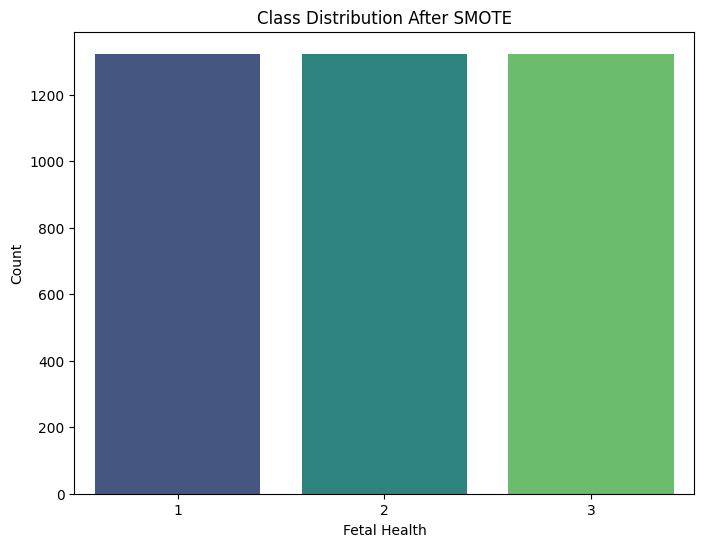

In [6]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("\nClass Distribution After SMOTE:")
print(y_train_resampled.value_counts())

# Visualize the resampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

In [7]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the resampled training data and transform
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_resampled.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Verify scaling by checking means and standard deviations
print("\nMean of Scaled Training Features (Should be ~0):")
print(X_train_scaled.mean())

print("\nStandard Deviation of Scaled Training Features (Should be ~1):")
print(X_train_scaled.std())


Mean of Scaled Training Features (Should be ~0):
baseline value                                            5.657130e-16
accelerations                                            -5.728740e-17
fetal_movement                                            1.432185e-17
uterine_contractions                                     -4.296555e-17
light_decelerations                                      -3.580462e-17
severe_decelerations                                      7.160925e-17
prolongued_decelerations                                 -1.718622e-16
abnormal_short_term_variability                           0.000000e+00
mean_value_of_short_term_variability                      5.012647e-17
percentage_of_time_with_abnormal_long_term_variability   -5.728740e-17
mean_value_of_long_term_variability                      -8.593109e-17
histogram_width                                           9.130179e-17
histogram_min                                             3.705778e-16
histogram_max              

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5110
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Confusion Matrix:
[[325   5   2]
 [ 11  45   3]
 [  2   1  32]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       332
     Suspect       0.88      0.76      0.82        59
Pathological       0.86      0.91      0.89        35

    accuracy                           0.94       426
   macro avg       0.90      0.89 

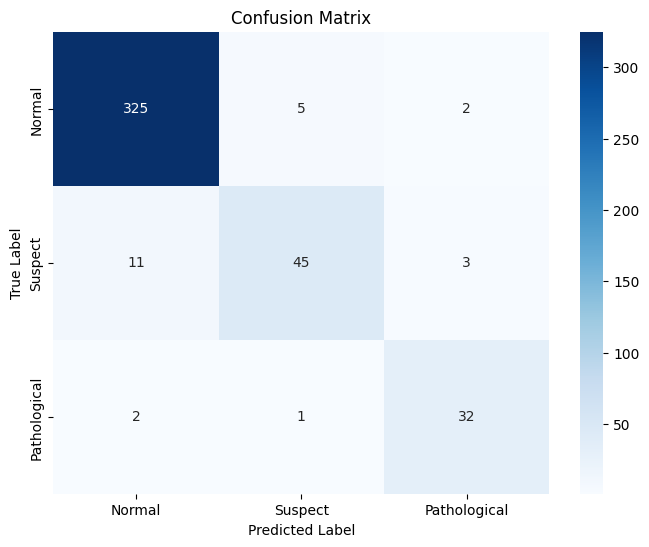

In [8]:
# Initialize the LightGBM Classifier
lgbm_classifier = LGBMClassifier(n_estimators=100, random_state=42)

# Train the model on the resampled and scaled training data
lgbm_classifier.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = lgbm_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Normal', 'Suspect', 'Pathological'])
print("\nClassification Report:")
print(class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [9]:
# Extract feature importances
importances = lgbm_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))



Top 10 Feature Importances:
                                              Feature  Importance
7                     abnormal_short_term_variability         972
9   percentage_of_time_with_abnormal_long_term_var...         969
0                                      baseline value         641
17                                     histogram_mean         606
3                                uterine_contractions         514
1                                       accelerations         459
16                                     histogram_mode         456
14                          histogram_number_of_peaks         453
10                mean_value_of_long_term_variability         419
13                                      histogram_max         414


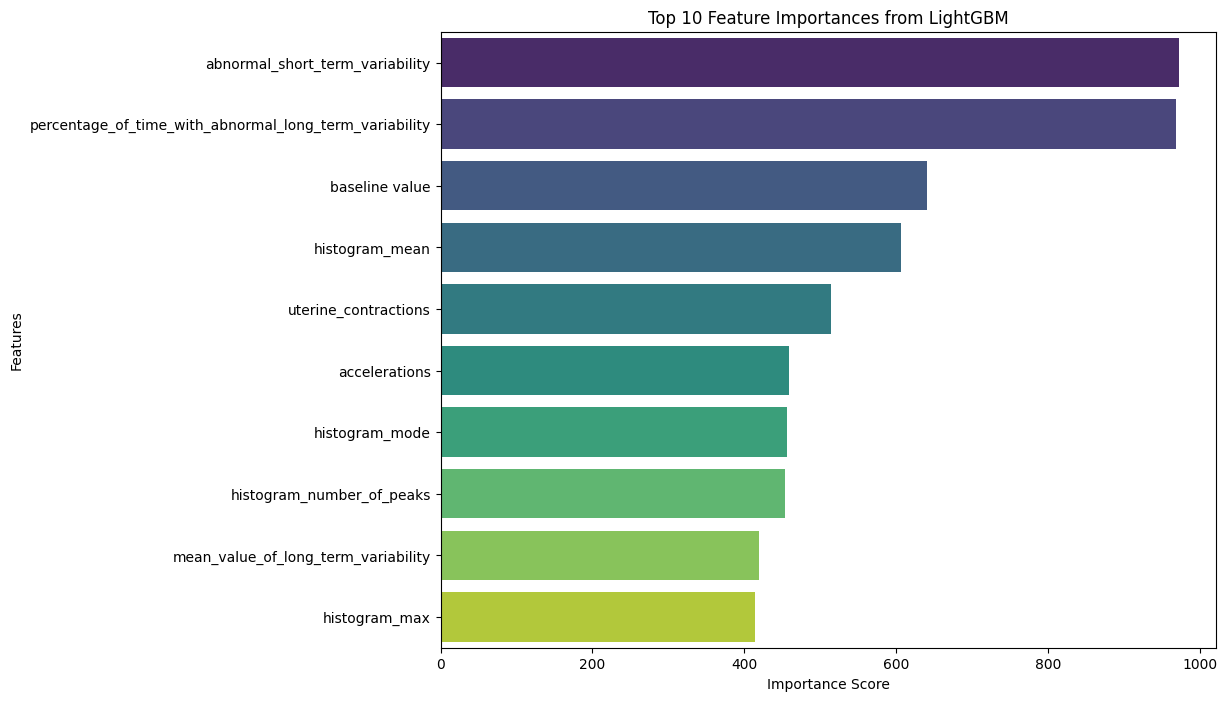

In [10]:
# Visualize Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances from LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [11]:
# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(lgbm_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Step 9.b: SHAP Summary Plot with Correct Indexing

import shap
import matplotlib.pyplot as plt

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(lgbm_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Verify the structure of shap_values
print(f"Type of shap_values: {type(shap_values)}")
print(f"Shape of shap_values: {shap_values.shape}")
print(f"Model classes: {lgbm_classifier.classes_}")


Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (426, 21, 3)
Model classes: [1 2 3]



Generating SHAP Summary Plot for class: Normal
Shape of shap_values_class for Normal: (426, 21)


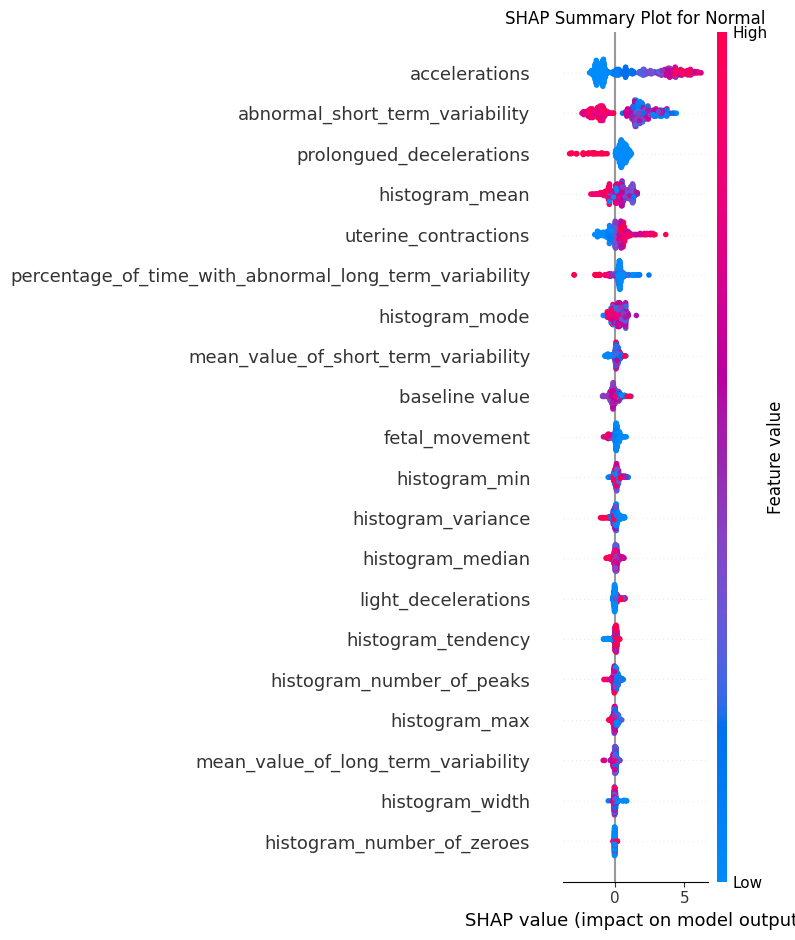


Generating SHAP Summary Plot for class: Suspect
Shape of shap_values_class for Suspect: (426, 21)


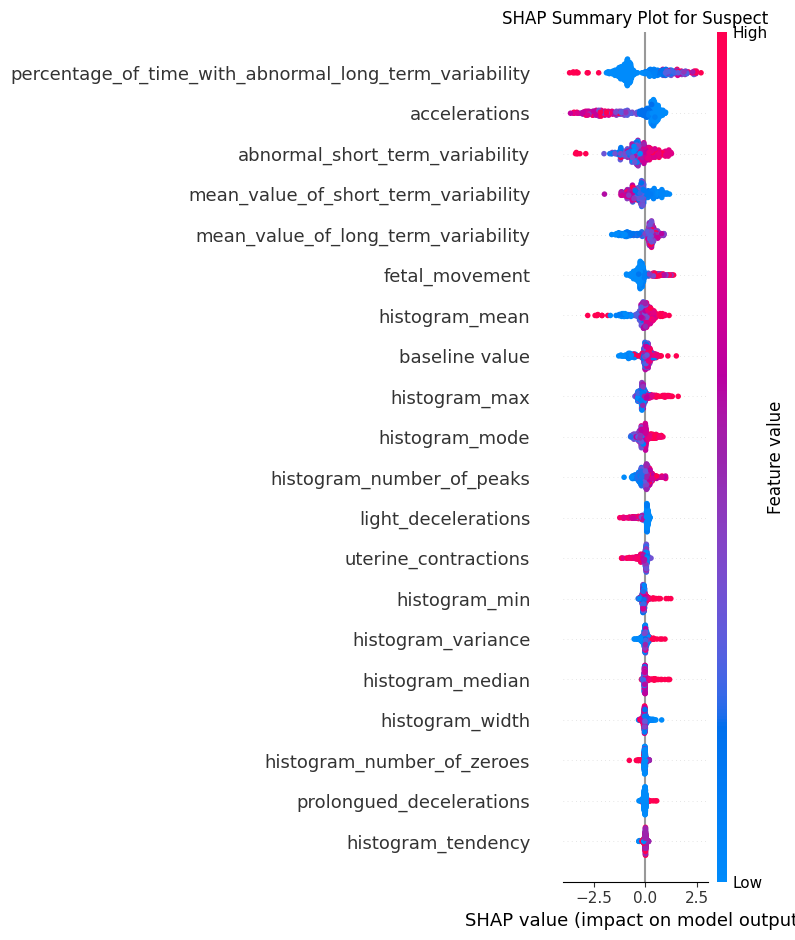


Generating SHAP Summary Plot for class: Pathological
Shape of shap_values_class for Pathological: (426, 21)


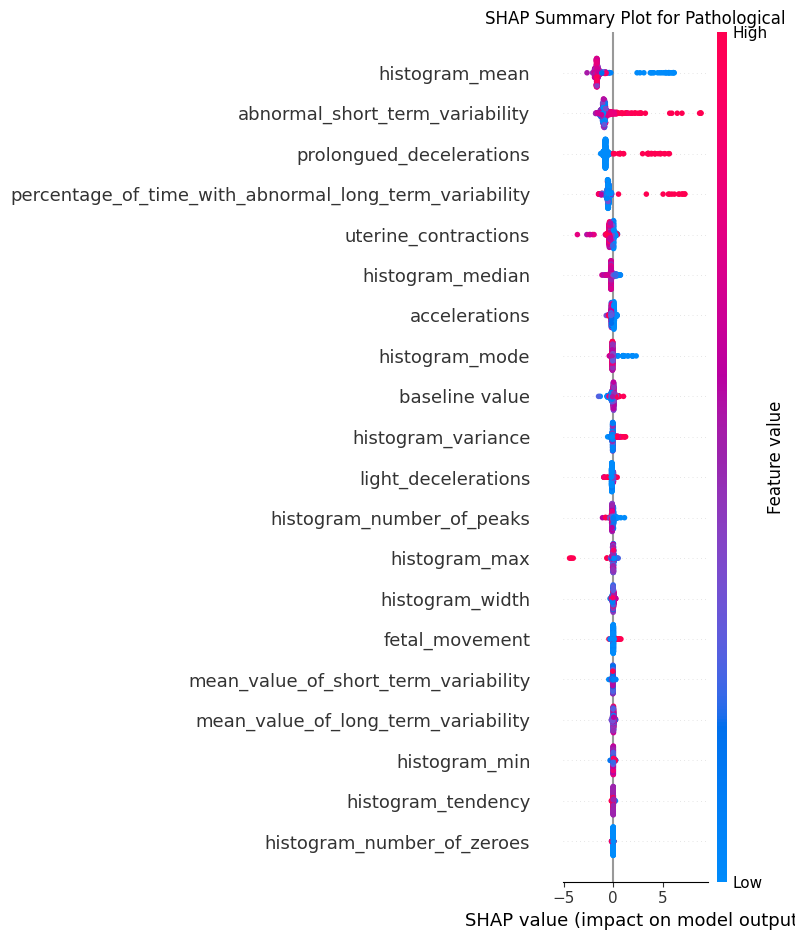

In [13]:
# Define class names for plotting
class_names = ['Normal', 'Suspect', 'Pathological']

# Loop through each class to generate SHAP summary plots
for i, class_name in enumerate(class_names):
    print(f"\nGenerating SHAP Summary Plot for class: {class_name}")

    # Extract SHAP values for the current class
    shap_values_class = shap_values[:, :, i]

    # Verify the shape
    print(f"Shape of shap_values_class for {class_name}: {shap_values_class.shape}")

    # Generate the SHAP summary plot
    shap.summary_plot(
        shap_values_class,
        X_test_scaled,
        feature_names=X.columns,
        show=False
    )

    # Set the title for the plot
    plt.title(f'SHAP Summary Plot for {class_name}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (426, 21, 3)
Shape of X_test_scaled: (426, 21)

SHAP Summary Bar Plot for class: Pathological


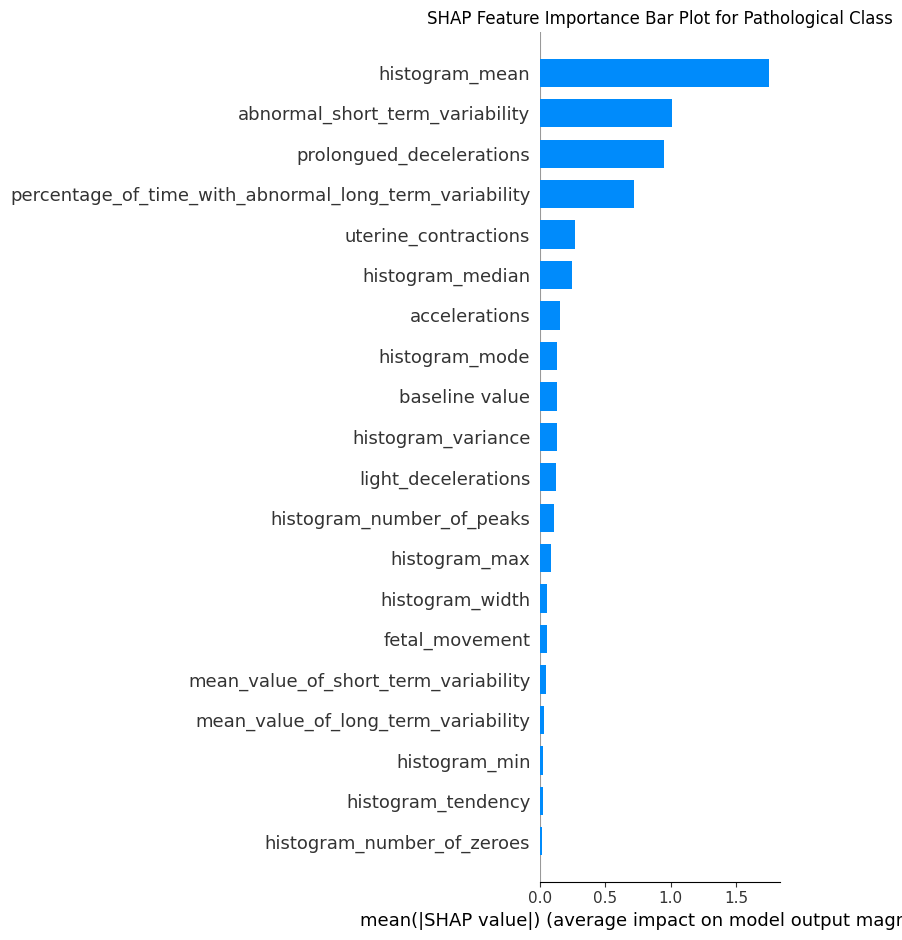

In [16]:
# Check the type and structure of shap_values
print(f"Type of shap_values: {type(shap_values)}")

# If shap_values is a list, print the length and shape of each element
if isinstance(shap_values, list):
    print(f"Number of classes: {len(shap_values)}")
    for idx, sv in enumerate(shap_values):
        print(f"Shape of shap_values[{idx}] for class {lgbm_classifier.classes_[idx]}: {sv.shape}")
else:
    # For binary classification, shap_values may not be a list
    print(f"Shape of shap_values: {shap_values.shape}")

# Verify X_test_scaled shape
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

# SHAP summary bar plot for the 'Pathological' class
class_index = 2  # Assuming 'Pathological' is the third class

print(f"\nSHAP Summary Bar Plot for class: Pathological")
shap.summary_plot(
    shap_values[:, :, class_index],
    X_test_scaled,
    plot_type="bar",
    feature_names=X.columns,
    show=False
)
plt.title('SHAP Feature Importance Bar Plot for Pathological Class')
plt.tight_layout()
plt.show()



SHAP Dependence Plot for feature: abnormal_short_term_variability


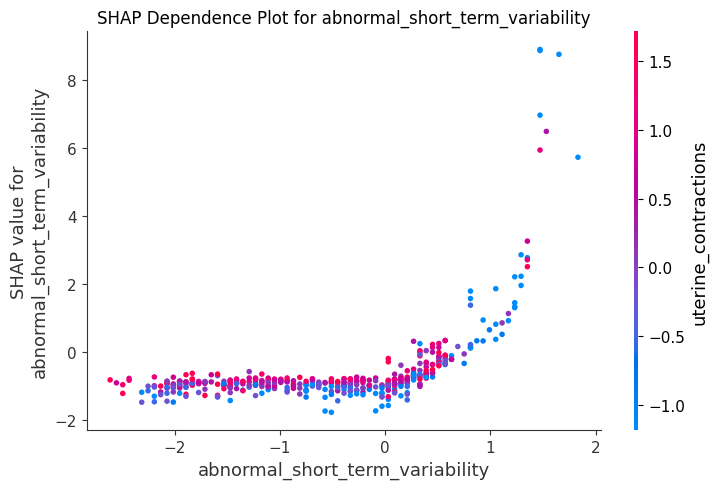

In [17]:
# Replace 'feature_name' with the actual feature you want to analyze
# For demonstration, we'll use the top feature from feature_importances
top_feature = feature_importances['Feature'].iloc[0]
print(f"\nSHAP Dependence Plot for feature: {top_feature}")
shap.dependence_plot(
    top_feature,
    shap_values[:, :, class_index],
    X_test_scaled,
    feature_names=X.columns,
    show=False
)
plt.title(f'SHAP Dependence Plot for {top_feature}')
plt.tight_layout()
plt.show()

# Select an instance to explain (e.g., the first instance in the test set)
instance_index = 0
instance = X_test_scaled.iloc[instance_index]

# Generate SHAP values for the instance
instance_shap_values = shap_values[instance_index, :, class_index]


SHAP Force Plot for instance index: 0 (Pathological Class)


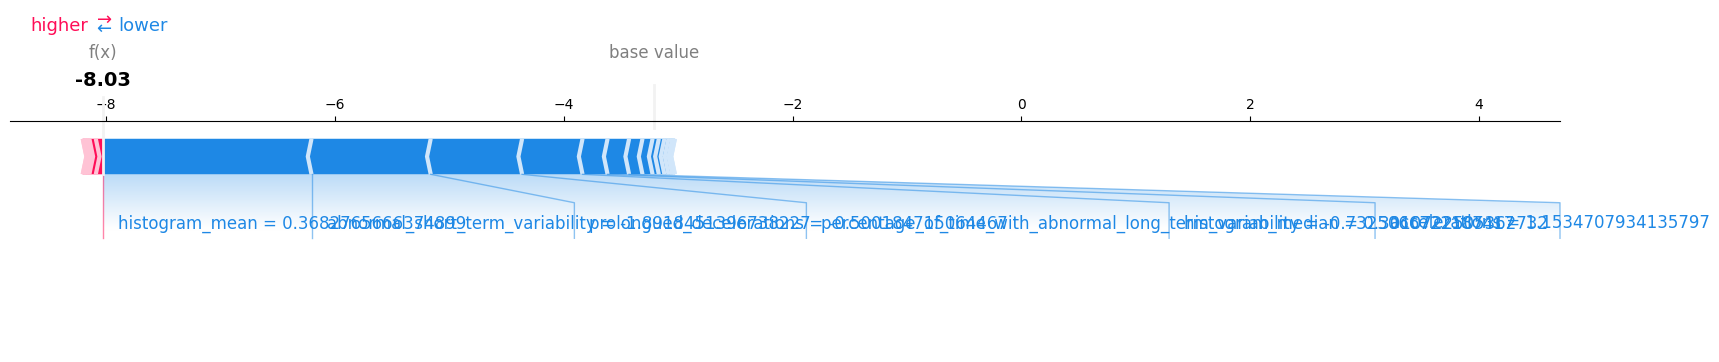

In [18]:
# Create a force plot for the 'Pathological' class
print(f"\nSHAP Force Plot for instance index: {instance_index} (Pathological Class)")
shap.initjs()
shap.force_plot(
    explainer.expected_value[class_index],
    instance_shap_values,
    instance,
    feature_names=X.columns,
    matplotlib=True
)
plt.show()

In [20]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set
perm_importance = permutation_importance(lgbm_classifier, X_test_scaled, y_test,
                                         n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

# Display the top 10 permutation importances
print("\nTop 10 Permutation Feature Importances:")
print(perm_importance_df.head(10))


Top 10 Permutation Feature Importances:
                                              Feature  Importance       Std
7                     abnormal_short_term_variability    0.075978  0.009782
1                                       accelerations    0.066432  0.010306
9   percentage_of_time_with_abnormal_long_term_var...    0.040219  0.006349
17                                     histogram_mean    0.034742  0.009200
3                                uterine_contractions    0.020579  0.005929
16                                     histogram_mode    0.014397  0.004401
19                                 histogram_variance    0.013067  0.004315
14                          histogram_number_of_peaks    0.011815  0.004635
2                                      fetal_movement    0.010955  0.003801
13                                      histogram_max    0.009390  0.003928


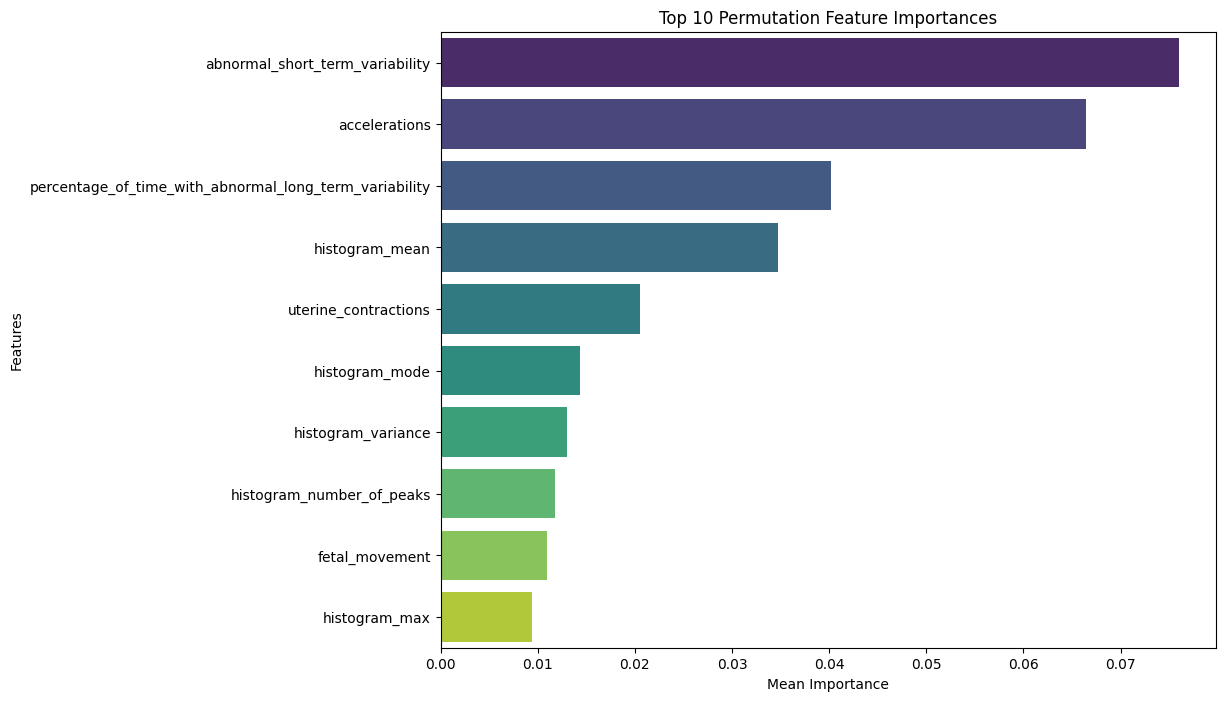

In [21]:
# Visualize Permutation Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(10), palette='viridis')
plt.title('Top 10 Permutation Feature Importances')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.show()

In [22]:
# Step 10.b: Define Class Names and Initialize Data Structures (Without 'Feature')

# Define class names corresponding to class indices
class_names = ['Normal', 'Suspect', 'Pathological']

# Initialize an empty dictionary to store SHAP statistics (Exclude 'Feature')
shap_stats = {
    'Normal_mean_SHAP': [],
    'Normal_mean_abs_SHAP': [],
    'Suspect_mean_SHAP': [],
    'Suspect_mean_abs_SHAP': [],
    'Pathological_mean_SHAP': [],
    'Pathological_mean_abs_SHAP': []
}

# Step 10.c: Calculate SHAP Statistics for Each Class

import numpy as np  # Ensure numpy is imported

# Iterate through each class to compute SHAP statistics
for i, class_name in enumerate(class_names):
    # Extract SHAP values for the current class
    shap_values_class = shap_values[:, :, i]  # Shape: (426, 21)

    # Compute mean SHAP value per feature for the class
    mean_shap = np.mean(shap_values_class, axis=0)  # Shape: (21,)

    # Compute mean absolute SHAP value per feature for the class
    mean_abs_shap = np.mean(np.abs(shap_values_class), axis=0)  # Shape: (21,)

    # Store the results in the dictionary
    shap_stats[f'{class_name}_mean_SHAP'] = mean_shap
    shap_stats[f'{class_name}_mean_abs_SHAP'] = mean_abs_shap

# Step 10.d: Create the SHAP Feature Importance DataFrame

import pandas as pd  # Ensure pandas is imported

# Create a DataFrame from the shap_stats dictionary
shap_importance_df = pd.DataFrame(shap_stats)

# Add the 'Feature' column from X.columns
shap_importance_df['Feature'] = X.columns

# Rearrange columns to place 'Feature' first
shap_importance_df = shap_importance_df[['Feature',
                                         'Normal_mean_SHAP',
                                         'Normal_mean_abs_SHAP',
                                         'Suspect_mean_SHAP',
                                         'Suspect_mean_abs_SHAP',
                                         'Pathological_mean_SHAP',
                                         'Pathological_mean_abs_SHAP']]


In [24]:
# Optionally, sort the DataFrame based on 'Normal_mean_abs_SHAP' in descending order
shap_importance_df = shap_importance_df.sort_values(by='Normal_mean_abs_SHAP', ascending=False).reset_index(drop=True)

# Step 10.f: Display the SHAP Feature Importance Table

print("SHAP Feature Importance Table:")
print(shap_importance_df)

# Save the table to a CSV file
shap_importance_df.to_csv('SHAP_Feature_Importances.csv', index=False)

print("Feature importance table saved as 'SHAP_Feature_Importances.csv'.")

SHAP Feature Importance Table:
                                              Feature  Normal_mean_SHAP  \
0                                       accelerations          1.214976   
1                     abnormal_short_term_variability          1.103567   
2                            prolongued_decelerations          0.411232   
3                                      histogram_mean          0.363561   
4                                uterine_contractions          0.267358   
5   percentage_of_time_with_abnormal_long_term_var...          0.255691   
6                                      histogram_mode          0.281688   
7                mean_value_of_short_term_variability          0.121220   
8                                      baseline value         -0.003367   
9                                      fetal_movement          0.086684   
10                                      histogram_min          0.153624   
11                                 histogram_variance          0.0526